In [1]:
import sys
sys.path.append("../../scripts/")
import torch 
from astropy.io import fits
from astropy.visualization import ImageNormalize, AsinhStretch
import numpy as np
import matplotlib.pyplot as plt
from torch.func import vmap, grad
from tqdm import tqdm
from scipy.stats import binned_statistic_2d
import mpol.constants as const
from mpol import coordinates
from mpol.gridding import DirtyImager
from scipy.spatial import cKDTree

from functools import partial

# from scipy import signal

plt.rcParams["figure.dpi"] = 150
plt.rcParams["font.size"] = 10
from score_models import ScoreModel, NCSNpp
import json

plt.style.use("dark_background")

from utils import fits_to_tensor
device = "cuda" if torch.cuda.is_available() else "cpu"

# Importing the models hparams and weights
path = "/home/mjybarth/projects/rrg-lplevass/data/"

file = open(path + "score_models/ncsnpp_ct_g_220912024942/model_hparams.json")
model_hparams = json.load(file)
sigma_min, sigma_max = model_hparams["sigma_min"], model_hparams["sigma_max"]

# Importing the weights
# score_model = ScoreModel(checkpoints_directory="/home/aadam/scratch/DeblendingGalaxies/models/ncsnpp_vp_probes_g_256_230824141338/")
# score_model = ScoreModel(checkpoints_directory="/home/aadam/scratch/DeblendingGalaxies/models/ncsnpp_vp_probes_z_256_230824141341/")
score_model = ScoreModel(checkpoints_directory="/home/mjybarth/projects/rrg-lplevass/data/score_models/ncsnpp_vp_skirt_z_256_230813225243/")

Using the Variance Preserving SDE


In [2]:
# Just take the first spectral window: 
data = np.load(path+"/HTLup_continuum_full.npz")

u = data["uu"]
v = data["vv"]
vis = data["data"]
weight = data["weight"]
vis_per_spw = data["vis_per_spw"]
# print(vis_per_spw)
freq_per_spw = data["freq_per_spw"]
chans_per_spw = np.array([8, 16, 16, 16, 8, 16, 16, 16, 16, 16, 16, 8, 16, 16, 16, 8]) # need to read those from CASA in the future

n_spw = len(vis_per_spw)
# print(n_spw)
#spw = 13 # pick spectral window
#print(vis_per_spw[spw])

idx_freq = np.cumsum(chans_per_spw)
idx_freq_inf = 0
#if spw == 0: 
#    idx_freq_inf = 0
#else: 
#    idx_freq_inf = idx_freq[spw-1]
idx_freq_sup = idx_freq[-1]
freqs_spw = freq_per_spw[idx_freq_inf:idx_freq_sup]
freq = np.mean(freqs_spw)

#idx_inf = vis_per_spw[:spw-1].sum()
#idx_sup = vis_per_spw[:spw].sum()
#u = u[idx_inf:idx_sup]
#v = v[idx_inf:idx_sup]
#vis = vis[idx_inf:idx_sup]
#weight = weight[idx_inf:idx_sup]

# Noé don't forget your minus signs when taking Hermitian conjugates
uu = np.concatenate([u, -u])
vv = np.concatenate([v, -v])

vis_re = np.concatenate([vis.real, vis.real])
vis_imag = np.concatenate([vis.imag, -vis.imag])
weight_ = np.concatenate([weight, weight])

In [3]:
def grid(pixel_scale, img_size): 
    """Given a pixel scale and a number of pixels in image space, grid the associated Fourier space

    Args:
        pixel_scale (float): Pixel resolution (in arcsec)
        img_size (float/int): Size of the image 

    Returns:
        
    """

    # Arcsec to radians: 
    dl = pixel_scale * const.arcsec
    dm = pixel_scale * const.arcsec

    du = 1 / (img_size * dl) * 1e-3 # klambda
    dv = 1 / (img_size * dm) * 1e-3 # klambda

    u_min = -img_size//2 * du 
    u_max = img_size//2 * du 

    v_min = -img_size//2 * dv
    v_max = img_size//2 * dv

    u_edges = np.linspace(u_min, u_max, img_size + 1)
    v_edges = np.linspace(v_min, v_max, img_size + 1)

    return u_edges, v_edges


def plot_uv_coverage(u, v, grid = False): 
    # Plot the uv coverage, if grid = True, plot the associated grid
    plt.scatter(u, v, s=0.5, rasterized=True, linewidths=0.0, c="r")

    if grid: 
        for x_coord in u_edges: 
            plt.axvline(x = x_coord, color = "gray", linestyle = "-", alpha = 0.5)

        for y_coord in v_edges:
            plt.axhline(y =y_coord, color = "gray", linestyle = "-", alpha = 0.5)
        

    plt.xlim([u.min(), u.max()])
    plt.ylim([v.min(), v.max()])
    plt.gca().set_aspect("equal")
    

# Gridding

In [4]:
pixel_scale = 0.0015
# pad = 768//2 # padding to 1024 pixels
pad = (4096 - 256)//2 # padding to 2048
# pad = 128 # padding to 512
img_size = 256
npix = img_size + 2 * pad
u_edges, v_edges = grid(pixel_scale = pixel_scale, img_size = npix)
pixel_size = u_edges[1] - u_edges[0] # this is delta_u, and we should probably call it that in the future. My bad

In [5]:
print(pixel_size)

33.57174580844003


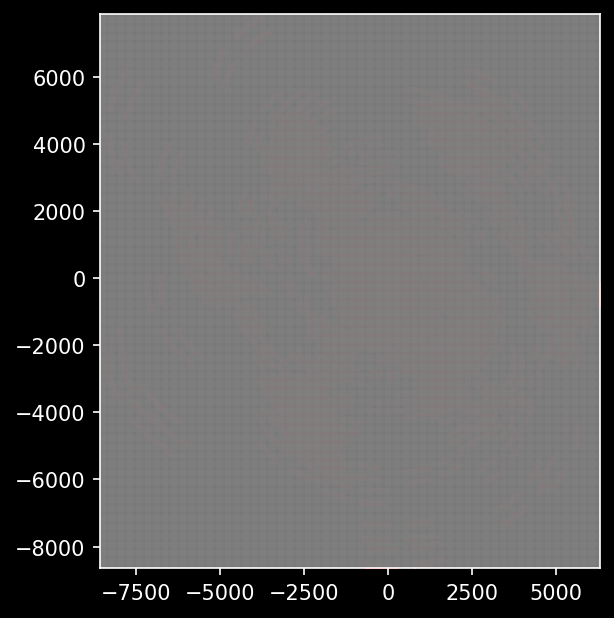

In [6]:
plot_uv_coverage(u, v, grid = True)

## Define a bank of convolutional window and their Fourier transform

In [7]:
def pillbox_window(u, center, pixel_size=pixel_size, m=1):
    """
    u: coordinate of the data points to be aggregated (u or v)
    center: coordinate of the center of the pixel considered. 
    pixel_size: Size of a pixel in the (u,v)-plane
    m: size of the truncation of this window (in term of pixel_size)
    """
    return np.where(np.abs(u - center) <= m * pixel_size / 2, 1, 0)


def sinc_window(u, center, pixel_size=pixel_size, m=1):
    """
    u: coordinate of the data points to be aggregated (u or v)
    center: coordinate of the center of the pixel considered. 
    pixel_size: Size of a pixel in the (u,v)-plane
    m: size of the truncation of this window (in term of pixel_size)
    """
    return np.sinc(np.abs(u - center) / m / pixel_size)

In [ ]:
from typing import Callable
def bin_data(u, v, values, weights, bins, window_fn, truncation_radius, statistics_fn="mean", verbose=0):
    u_edges = bins[0]
    v_edges = bins[1]
    n_coarse = 0
    grid = np.zeros((len(u_edges)-1, len(v_edges)-1))
    if verbose:
        print("Fitting the KD Tree on the data...")
    # Build a cKDTree from the data points coordinates to query uv points in our truncation radius
    uv_grid = np.vstack((u.ravel(), v.ravel())).T
    tree = cKDTree(uv_grid)
    if verbose:
        print("Gridding...")
    for i in tqdm(range(len(u_edges)-1), disable=not verbose):
        for j in range(len(v_edges)-1):
            # Calculate the coordinates of the center of the current cell in our grid
            u_center = (u_edges[i] + u_edges[i+1])/2
            v_center = (v_edges[j] + v_edges[j+1])/2
            # Query the tree to find the points within the truncation radius of the cell
            indices = tree.query_ball_point([u_center, v_center], truncation_radius, p=1) # p=1 is the Manhattan distance (L1)
            # Apply the convolutional window and weighted averaging
            if len(indices) > 0:
                value = values[indices]
                weight = weights[indices] * window_fn(u[indices], u_center) * window_fn(v[indices], v_center)
                #if len(indices) == 1 and verbose > 1:
                    #print(f"Cell {(i, j)} has a single visibility and weight {weight.sum()} {weight}...")
                if weight.sum() > 0.: # avoid dividing by a normalization = 0
                    if statistics_fn=="mean":
                        grid[j, i] = (value * weight).sum() / weight.sum()
                    elif statistics_fn=="std":
                        m = 1
                        if (weight > 0).sum() < 5:
                            # run statistics on a larger neighborhood
                            while (weight > 0).sum() < 5: # this number is a bit arbitrary, we just hope to get better statistics
                                m += 0.1
                                indices = tree.query_ball_point([u_center, v_center], m*truncation_radius, p=1) # p=1 is the Manhattan distance (L1)
                                value = values[indices]
                                weight = weights[indices] * window_fn(u[indices], u_center, m = m) * window_fn(v[indices], v_center, m = m)
                            #print(f"Coarsened pixel to {m} times its size, now has {len(indices)} for statistics")
                            n_coarse += 1
                        # See https://en.wikipedia.org/wiki/Weighted_arithmetic_mean
                        # See more specifically the bootstrapping
                        if np.sum(weight > 0) < 2:
                            print("Low weight")
                        
                        #N_eff taken from Bevington, see the page: http://seismo.berkeley.edu/~kirchner/Toolkits/Toolkit_12.pdf
                        importance_weights = window_fn(u[indices], u_center, m = m) * window_fn(v[indices], v_center, m = m)
                        n_eff = np.sum(importance_weights)**2 / np.sum(importance_weights**2)
                        grid[j, i] = np.sqrt(np.cov(value, aweights=weight, ddof = 0)) * (n_eff / (n_eff - 1)) * 1/(np.sqrt(n_eff))
                    elif statistics_fn=="count":
                        grid[j, i] = (weight > 0).sum()
                    elif isinstance(statistics_fn, Callable):
                        grid[j, i] = statistics_fn(value, weight)
    print(f"number of coarsened pix: {n_coarse}")
    return grid

## Compute binned std statistics based on coarser grid to avoid cell with a single visibility

In [ ]:
pixel_size / 2

16.785872904220014

In [ ]:
truncation_radius = pixel_size
window_fn = partial(sinc_window, pixel_size=pixel_size)

# Real part mean and count
args = (uu, vv, vis_re, weight_, (u_edges, v_edges), window_fn, truncation_radius)
vis_bin_re = bin_data(*args, statistics_fn="mean", verbose=1)
std_bin_re = bin_data(*args, statistics_fn="std", verbose=2)
counts = bin_data(*args, statistics_fn="count", verbose=1)

# Image part mean
args = (uu, vv, vis_imag, weight_, (u_edges, v_edges), window_fn, truncation_radius)
vis_bin_imag = bin_data(*args, statistics_fn="mean", verbose=1)
std_bin_imag = bin_data(*args, statistics_fn="std", verbose=2)

Fitting the KD Tree on the data...


In [ ]:
len(std_bin_imag)

In [ ]:
np.sum(np.isnan(std_bin_imag))

In [ ]:
np.sum(np.isnan(std_bin_re))

In [ ]:
# From object type to float
vis_bin_re = vis_bin_re.astype(float)
vis_bin_imag = vis_bin_imag.astype(float)
std_bin_re = std_bin_re.astype(float) 
std_bin_imag = std_bin_imag.astype(float)
counts = counts.astype(float)

# i.e. The sampling function where there is data in the uv plane
mask = counts > 0

# Upsample std 
from scipy import interpolate
def upsample(input_data, d):
    # Get the shape of the input grid
    rows, cols = input_data.shape
    # Define the x and y coordinates of the original grid
    x = np.linspace(0, cols - 1, cols)
    y = np.linspace(0, rows - 1, rows)
    
    # Create a bilinear interpolator object
    f_interp = interpolate.interp2d(x, y, input_data, kind='linear')
    
    # Define the x and y coordinates of the upsampled grid
    x_new = np.linspace(0, cols - 1, cols * d)
    y_new = np.linspace(0, rows - 1, rows * d)
    
    # Perform the interpolation to upsample the grid
    upsampled_data = f_interp(x_new, y_new)
    return upsampled_data

# upsample std if needed
if std_bin_re.shape[0] < vis_bin_re.shape[0]:
    assert vis_bin_re.shape[0] // std_bin_re.shape[0] == downsampling_factor
    std_bin_re = upsample(std_bin_re, downsampling_factor)
if std_bin_imag.shape[0] < vis_bin_imag.shape[0]:
    assert vis_bin_imag.shape[0] // std_bin_imag.shape[0] == downsampling_factor
    std_bin_imag = upsample(std_bin_imag, downsampling_factor)

#I am commenting this out and performing this process inside the binning function
#std_bin_re /= (counts + 1)**0.5
#std_bin_imag /= (counts + 1)**0.5

# For the inference, fftshift is done in the forward model
vis_gridded_re = np.fft.fftshift(vis_bin_re).flatten()
vis_gridded_imag = np.fft.fftshift(vis_bin_imag).flatten()
std_gridded_re = np.fft.fftshift(std_bin_re).flatten()
std_gridded_imag = np.fft.fftshift(std_bin_imag).flatten()
S_grid = np.fft.fftshift(mask).flatten()

In [ ]:
def plot_dirty_image(vis_gridded): 
    dirty_image = npix ** 2 * np.fft.fftshift(np.fft.ifft2(vis_gridded))[::-1].real
    im = plt.imshow(dirty_image, origin = "lower", cmap = "magma")  # flip needed due to CASA's convention  
    plt.colorbar(im, fraction = 0.046, label = "Jy/beam ?")

# To compute the dirty image
vis_grid = np.fft.fftshift(vis_bin_re + 1j * vis_bin_imag)

dirty_image = plot_dirty_image(vis_grid)

In [ ]:
def plot_dirty_image(vis_gridded): 
    dirty_image = npix ** 2 * np.fft.fftshift(np.fft.ifft2(vis_gridded))[::-1].real
    im = plt.imshow(np.rot90(dirty_image[2048-256:2048+256, 2048-256:2048+256], k = 2), origin = "lower", cmap = "magma", vmin = 0.5)  # flip needed due to CASA's convention  
    plt.colorbar(im, fraction = 0.046, label = "Jy/beam ?")
    
dirty_image = plot_dirty_image(vis_grid)

In [ ]:
# Numpy to torch: 
S_cat = np.concatenate([S_grid, S_grid])
vis_gridded = np.concatenate([vis_gridded_re, vis_gridded_imag])
std_gridded = np.concatenate([std_gridded_re, std_gridded_imag])

S = torch.tensor(S_cat).to(device)
y = torch.tensor(vis_gridded, device = S.device)[S].to(device) * npix
sigma_y = torch.tensor(std_gridded, device = S.device)[S].to(device) * npix

In [ ]:
print(f"Max, min, mean y: {y.max():.2g}, {y.min():.2g}, {y.mean():.2g}")
print(f"Max, min, mean sigma_y: {sigma_y.max():.2g}, {sigma_y.min():.2g}, {sigma_y.mean():.2g}")

In [ ]:
torch.isnan(sigma_y).sum() # this should be 0

In [ ]:
def ft(x): 
    return torch.fft.fft2(x, norm = "ortho")

# C = 0.5 # VE prior
# B = 0.5 # VE
C = 1 # VP prior
B = 0 # VP
def link_function(x):
    return C * x + B

def flip(x): 
    return x[:, ::-1]

In [ ]:
def noise_padding(x, pad, sigma):
    H, W = x.shape
    out = torch.nn.functional.pad(x, (pad, pad, pad, pad)) 
    # Create a mask for padding region
    mask = torch.ones_like(out)
    mask[pad:pad + H, pad:pad+W] = 0.
    # Noise pad around the model
    z = torch.randn_like(out) * sigma
    out = out + z * mask
    return out

# Primary beam (not used yet)

In [ ]:
# We will use this later
def generate_pb(diameter = 12, freq = 432058061289.4426, shape = (500, 500), deltal = 0.004):
    #Some credit to ChatGPT....I got lazy lol
    wavelength = c / freq
    fwhm = 1.02 * wavelength / diameter * (180/torch.pi) * (3600)
    half_fov = deltal * shape[0] / 2
    #Grid for PB
    x = np.linspace(-half_fov, half_fov, shape[0])
    y = np.linspace(-half_fov, half_fov, shape[1])
    x, y = np.meshgrid(x, y)
    #Gaussian PB parameters
    mean = [0, 0]  # Mean (center) of the Gaussian
    std = fwhm / (2*np.sqrt(2*np.log(2)))
    covariance_matrix = np.array([[std, 0], [0, std]])  # Covariance matrix
    # 2-D Gaussian PB
    x_y = np.column_stack([x.ravel(), y.ravel()])
    pb = (
        1 / (2 * np.pi * np.sqrt(np.linalg.det(covariance_matrix)))
    ) * np.exp(-0.5 * np.sum(np.dot(x_y - mean, np.linalg.inv(covariance_matrix)) * (x_y - mean), axis=1))
    # Reshape the PDF values to match the shape of the grid
    pb = pb.reshape(x.shape)
    return pb, fwhm

In [ ]:
# w = torch.hamming_window(npix)
w = torch.hann_window(npix)
w = torch.outer(w, w)
w = w.to(device)
plt.imshow(w.cpu())
plt.colorbar()

# Window function

When using a specific convolution window, we need to take it into account in our forward model. More specifically, we need to take the Fourier transform of our window function and multiply our solution by it when forward modeling. 

We alread did this exercise above for the Pillbox window function. Now we need to write correctly the sinc function in real space.


First, not that $u$ and $\Delta u$ are in $k\lambda$ units. We have access to the frequency of the channel we are studying, thus $\lambda = \frac{c}{f}$, where $c$ is the speed of light and $f$ is in Hz units. 

In order to compute $\text{sinc}(m\Delta u x)$, we have to convert the units of $x$, which are arcseconds, into $(k \lambda)^{-1}$. We can do this with the following trick

$$
    \frac{x}{3600} \times \frac{\pi}{180} \times \frac{f}{c} \times 10^{3}
$$


In [ ]:
from astropy.constants import c
from astropy import units

lam = (c / (freq * units.Hz)).decompose()

factor = 1 /3600 * np.pi / 180 * (1 / lam.value) * 1e3
print(factor)

lam # important that this be in meters

In [ ]:
delta_u

In [ ]:
fov = pixel_scale * npix
delta_u = pixel_size

#Alex's sinc with outer product...doesn't work
#x = np.linspace(-1, 1, npix) * fov / 2
#real_window = np.abs(delta_u)/(np.sqrt(2*np.pi)) * np.sinc(x * factor  * delta_u * 0.5)
#real_window = np.outer(real_window, real_window)
#real_window = torch.tensor(real_window).to(device)

#2D sinc...adds a weird bessel to our posterior samples
#x_linear, y_linear = np.linspace(-1, 1, npix) * fov / 2, np.linspace(-1, 1, npix) * fov / 2
#x_g, y_g = np.meshgrid(x_linear, y_linear)
#real_window = np.abs(delta_u)/(np.sqrt(2*np.pi)) * np.sinc(np.hypot(x_g, y_g) * factor  * delta_u * 2)
#real_window = torch.tensor(real_window).to(device)

m = npix//2
n = img_size
plt.imshow(real_window.cpu(), cmap="magma", norm=plt.cm.colors.LogNorm())
plt.colorbar()

In [ ]:
def sigma(t):
    return score_model.sde.sigma(t)

def mu(t):
    return score_model.sde.marginal_prob_scalars(t)[0]

def model(x, t):
    x = x.reshape(img_size, img_size) # for the FFT 
    x = noise_padding(x, pad=pad, sigma=sigma(t))
    x = link_function(x) # map from model unit space to real unit space
    #x = real_window * x
    vis_full = ft(torch.fft.fftshift(x)).flatten() 
    vis_sampled = vis_full
    vis_sampled = torch.cat([vis_sampled.real, vis_sampled.imag])
    return vis_sampled[S]


def log_likelihood(y, x, t, sigma_y):
    """
    Calculate the log-likelihood of a gaussian distribution 
    Arguments: 
        y = processed gridded visibilities (real part and imaginary part concatenated)
        x = sky brightness 
        t = diffusion temperature
        A = linear model (sampling function and FT)  
    
    Returns: 
        log-likelihood of a gaussian distribution
    """ 
    y_hat = model(x, t)
    var = sigma(t) **2 / 2 * C**2 + mu(t)**2 * sigma_y**2
    log_prob = -0.5 * torch.sum((mu(t) * y - y_hat)**2 / var)
    return log_prob


# GIVE THE GOOD COVARIANCE MATRIX
def score_likelihood(y, x, t, sigma_y): 
    x = x.flatten(start_dim = 1)
    return vmap(grad(lambda x, t: log_likelihood(y, x, t, sigma_y)), randomness = "different")(x, t)

#torch.manual_seed(0)
def score_posterior(x, t): 
    x = x.reshape(-1, 1, img_size, img_size)
    return score_model.score(t, x).flatten(start_dim = 1) + score_likelihood(y, x, t, sigma_y) 

k = torch.randn([1, img_size ** 2]).to(device) 
t = torch.ones([1]).to(device)

print((torch.sum(score_likelihood(y, k, t, sigma_y)**2))**0.5)
print(score_posterior(k, t))

In [ ]:
t = torch.linspace(0, 1, 100)

plt.plot(t, mu(t), label=r"$\mu(t)$")
plt.plot(t, sigma(t), label=r"$\sigma(t)$")
plt.legend()

In [ ]:
# def g(t): 
    # return sigma(t) * np.sqrt(2 * (np.log(sigma_max) - np.log(sigma_min)))
    
def g(t, x):
    return score_model.sde.diffusion(t, x)

def drift_fn(t, x):
    return score_model.sde.drift(t, x)
    

def pc_sampler(num_samples, num_pred_steps, num_corr_steps, score_function, snr = 1e-2, img_size = 28): 
    t = torch.ones(size = (num_samples, 1)).to(device)
    x = torch.randn([num_samples, img_size ** 2]).to(device)
    dt = -1/num_pred_steps
    with torch.no_grad(): 
        for _ in tqdm(range(num_pred_steps-1)): 
            # Corrector step: (Only if we are not at 0 temperature )
            gradient = score_function(x, t)
            for _ in range(num_corr_steps): 
                z = torch.randn_like(x)
                grad_norm = torch.mean(torch.norm(gradient, dim = -1)) # mean of the norm of the score over the batch 
                noise_norm = torch.mean(torch.norm(z, dim = -1))
                epsilon =  2 * (snr * noise_norm / grad_norm) ** 2
                x = x + epsilon * gradient + (2 * epsilon) ** 0.5 * z * dt  

        
            # Predictor step: 
            z = torch.randn_like(x).to(device)
            gradient = score_function(x, t)
            drift = drift_fn(t, x)
            diffusion = g(t, x)
            x_mean = x - diffusion**2 * gradient * dt  
            noise = diffusion * (-dt) ** 0.5 * z
            x = x_mean + noise
            t += dt
            if torch.any(torch.isnan(x_mean)):
                print("Nans appearing")
                break
            
    return torch.flip(link_function(x_mean).reshape(num_samples, img_size, img_size), dims = (2,))

def euler_sampler(num_samples, num_steps, score_function, img_size = 28): 
    t = torch.ones(size = (num_samples, 1)).to(device)
    x = torch.randn([num_samples, img_size ** 2]).to(device) * sigma(t)
    dt = -1/num_steps
    
    chain = []
    with torch.no_grad(): 
        for _ in (pbar := tqdm(range(num_steps - 1))): 
            pbar.set_description(f"t = {t[0].item():.2f} | scale ~ {x.std():.2e} | sigma(t) = {sigma(t)[0].item():.2e} | mu(t) = {mu(t)[0].item():.2e}")
            t += dt
            z = torch.randn_like(x).to(device)
            gradient = score_function(x, t)
            drift = drift_fn(t, x)
            diffusion = g(t, x)
            x_mean = x + drift * dt - diffusion**2 * gradient * dt  
            noise = diffusion * (-dt) ** 0.5 * z
            x = x_mean + noise
            
            chain.append(x.cpu().numpy())

            #print(score_likelihood(x, t))
            if torch.any(torch.isnan(x_mean)):
                print("Nans appearing")
                break
    
    return torch.flip(link_function(x_mean).reshape(num_samples, img_size, img_size), dims = (2,)), chain

pred = 800
corr = 10
snr = 1e-2
num_samples = 1
samples, chain = euler_sampler(num_samples = num_samples, num_steps = pred, score_function = score_posterior, img_size = img_size)
#samples = pc_sampler(num_samples = 1, num_pred_steps = pred, num_corr_steps = corr, snr = snr, score_function = score_posterior, img_size = img_size)

In [ ]:
# plt.plot([_x.std() for _x in chain])

In [ ]:
# log_likelihood(y, torch.tensor(chain[0]).to(device), t=torch.ones(1).to(device), sigma_y=sigma_y)

In [ ]:
fig, axs = plt.subplots(2, 5, figsize=(20, 8))

t = torch.linspace(1, 0, len(chain))

for k, ax in enumerate(axs.flatten()):
    ind = k * pred // 10
    ax.imshow(chain[ind].reshape(256, 256), cmap="magma")
    ax.annotate(f"{t[ind]:.2f}", xy=(0.1, 0.9), xycoords="axes fraction")
    ax.axis("off")

In [ ]:
norm = False
save = False
n_images = samples.shape[0]
grid_size = int(n_images**0.5)
if n_images != 1:
    fig, axs = plt.subplots(grid_size, grid_size, figsize = (5, 5))
    norm = ImageNormalize(dirty_image[..., None, None].cpu().numpy(), vmin = 0, stretch = AsinhStretch())
    k = 0
    for i in range(grid_size):
        for j in range(grid_size): 
            im = axs[i, j].imshow((link_function(samples[k])).cpu().reshape(img_size, img_size), cmap = "magma", norm = norm, origin = "lower")
            axs[i, j].axis("off")
            #if k==0: 
                #plt.colorbar(im)
            k+=1
else: 
    print(norm)
    if norm:
        save_path = f"../../images/HTLup_pad{img_size}norm.jpeg"
        norm = ImageNormalize(samples.cpu().numpy(), vmin = 0, stretch = AsinhStretch())
    else: 
        save_path = f"../../images/HTLup_pad{img_size}nonorm.jpeg"
        norm = None
    plt.imshow(samples[0].cpu(), cmap = "magma", norm = norm, origin = "lower")
    plt.axis("off")
    plt.colorbar()
if save: 
    plt.savefig(save_path, bbox_inches = "tight", pad_inches = 0.1)

True


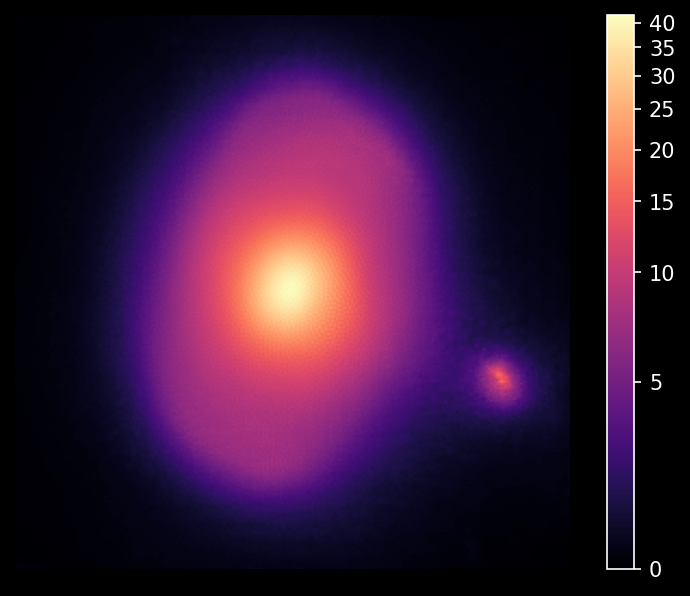

In [139]:
norm = True
save = False
n_images = samples.shape[0]
grid_size = int(n_images**0.5)
if n_images != 1:
    fig, axs = plt.subplots(grid_size, grid_size, figsize = (5, 5))
    norm = ImageNormalize(dirty_image[..., None, None].cpu().numpy(), vmin = 0, stretch = AsinhStretch())
    k = 0
    for i in range(grid_size):
        for j in range(grid_size): 
            im = axs[i, j].imshow((link_function(samples[k])).cpu().reshape(img_size, img_size), cmap = "magma", norm = norm, origin = "lower")
            axs[i, j].axis("off")
            #if k==0: 
                #plt.colorbar(im)
            k+=1
else: 
    print(norm)
    if norm:
        save_path = f"../../images/HTLup_pad{img_size}norm.jpeg"
        norm = ImageNormalize(samples.cpu().numpy(), vmin = 0, stretch = AsinhStretch())
    else: 
        save_path = f"../../images/HTLup_pad{img_size}nonorm.jpeg"
        norm = None
    plt.imshow(samples[0].cpu(), cmap = "magma", norm = norm, origin = "lower")
    plt.axis("off")
    plt.colorbar()
if save: 
    plt.savefig(save_path, bbox_inches = "tight", pad_inches = 0.1)

In [102]:
samples[0].cpu().shape

torch.Size([256, 256])